#### Import de librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import zipfile
import scipy.stats as st
from collections import Counter
from provided_python_code import *

#### Chargement des données et data cleaning

Chargement des données et data cleaning des données de la World Income Distribution

In [2]:
data = pd.read_csv('data-projet7.csv', decimal=',')
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [3]:
# la fonction 'describe' nous renseigne sur les données définies comme numérique d'un DataFrame
# on constate une incohérence avec le nombre de quantile
# Celui-ci censé être un nombre rond, comme le nombre de quartile moyen, minimum ou maximal, qui d'ailleurs ont eu valeur égale
# La variable 'gdpppp' semble présenter une valeur aberrante au niveau de son écart-type et sa valeur maximale
data.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
mean,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.877300e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


In [4]:
# la fonction 'info' nous informe sur le type de variable du DataFrame ainsi que le nomnbre de valeurs nulles par colonne
# la variable 'gdpppp' contient 200 valeurs nulles
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


In [5]:
# vérification d'éventuels doublons
data.duplicated().sum()

0

In [6]:
# nombre de valeurs nulles par variable
data.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

In [7]:
# DataFrame contenant les NaN de la variable 'gdpppp'
df_null=data[data['gdpppp'].isnull()==True]
df_null

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,NaN
5801,XKX,2008,2,100,508.17133,NaN
5802,XKX,2008,3,100,591.82820,NaN
5803,XKX,2008,4,100,668.00000,NaN
5804,XKX,2008,5,100,730.40220,NaN
...,...,...,...,...,...,...
11294,PSE,2009,96,100,2763.88480,NaN
11295,PSE,2009,97,100,3077.83330,NaN
11296,PSE,2009,98,100,3449.22240,NaN
11297,PSE,2009,99,100,4165.99700,NaN


In [8]:
# Remplacement des valeurs NaN
# ajout des valeurs manquantes pour la colonne 'gdpppp'
# correction pour la valeur correspondante à Fidji
# source : United Nation | Department of Economic and Social Affairs
data.loc[data['country']== 'XKX', 'gdpppp']= 3031
data.loc[data['country']== 'PSE', 'gdpppp']= 2043
data.loc[data['country']== 'FJI', 'gdpppp']= 4168

Rajout du quantile manquant

In [9]:
# recherche du pays conmprenant le quantile manquant
data.groupby('country').count().nsmallest(1, 'quantile')

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,99,99,99,99,99


In [10]:
# on recherche l'élément manquant par son numéro de quantile
liste=list(range(1,101))
ltu=data[data['country']=='LTU']

for i in liste:
    if (i not in list(ltu['quantile']))==True:
        print(i)

41


In [11]:
# plutôt que de supprimer toutes les infos concernant le pays, créons une moyenne entre les quantiles 40 et 42
ltu_qtl=data.loc[(data['country']=='LTU') & (data['quantile']==42) |
        (data['country']=='LTU') & (data['quantile']==40),'income'].mean()
ltu_qtl

4882.14065

In [12]:
# on crée la ligne manquante
df_ltu = pd.DataFrame({'country' :  ['LTU'],
                        'year_survey' : [2008],
                        'quantile' : [41],
                        'nb_quantiles' : [100],
                        'income' : [ltu_qtl],
                        'gdpppp'  :  [17571.0]})
df_ltu

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571.0


In [13]:
# contaténation du jeu de données et de la ligne manquante créée
data = pd.concat([data, df_ltu], ignore_index=True, sort=True)
data.sort_values(by=['country', 'quantile', 'year_survey'], inplace=True)

Chargement des données et data cleaning des données de la population

In [14]:
# source : World Development Indicators
pop=pd.read_csv('world_population_2004_to_2011.csv', skiprows=4)
pop=pop[["Country Name","Country Code", '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
pop

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,98744.0,100830.0,101226.0,101362.0,101452.0,101665.0,102050.0
1,NaN,AFE,441630149.0,465581372.0,478166911.0,491173160.0,504604672.0,518468229.0,532760424.0
2,Afghanistan,AFG,24726689.0,26433058.0,27100542.0,27722281.0,28394806.0,29185511.0,30117411.0
3,NaN,AFW,297353098.0,313985474.0,322741656.0,331772330.0,341050537.0,350556886.0,360285439.0
4,Angola,AGO,18758138.0,20149905.0,20905360.0,21695636.0,22514275.0,23356247.0,24220660.0
...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,1704622.0,1719536.0,1733404.0,1747383.0,1761474.0,1775680.0,1791000.0
262,"Yémen, Rép. du",YEM,19540096.0,20687648.0,21282514.0,21892149.0,22516464.0,23154854.0,23807586.0
263,Afrique du Sud,ZAF,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0
264,Zambie,ZMB,11550641.0,12173518.0,12502958.0,12848531.0,13215142.0,13605986.0,14023199.0


In [15]:
# la fonction 'describe' nous renseigne sur les données définies comme numérique d'un DataFrame
# la valeur max semble correspondre à la population mondiale
pop.describe()

,2004,2006,2007,2008,2009,2010,2011
count,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02
mean,2.579580e+08,2.648752e+08,2.683706e+08,2.719208e+08,2.754863e+08,2.790648e+08,2.826693e+08
std,8.162574e+08,8.367913e+08,8.470869e+08,8.575082e+08,8.679735e+08,8.784705e+08,8.891399e+08
min,9.871000e+03,9.827000e+03,9.846000e+03,9.880000e+03,9.945000e+03,1.000900e+04,1.006900e+04
25%,1.313492e+06,1.346810e+06,1.340680e+06,1.436670e+06,1.483920e+06,1.522603e+06,1.562996e+06
50%,8.680516e+06,9.043342e+06,9.148092e+06,9.219637e+06,9.298515e+06,9.483836e+06,9.461643e+06
75%,5.306887e+07,5.657805e+07,5.843831e+07,5.882673e+07,5.909536e+07,5.927742e+07,5.937945e+07
max,6.431527e+09,6.592712e+09,6.674182e+09,6.757000e+09,6.839554e+09,6.921855e+09,7.003760e+09


In [16]:
# nombre de valeurs nulles par variable
pop.isnull().sum()

Country Name    2
Country Code    0
2004            1
2006            1
2007            1
2008            1
2009            1
2010            1
2011            1
dtype: int64

In [17]:
# les 'Country Code' 'AFE' et 'AFW' ne correspondent à aucun pays
pop[pop['Country Name'].isna()==True]

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
1,NaN,AFE,441630149.0,465581372.0,478166911.0,491173160.0,504604672.0,518468229.0,532760424.0
3,NaN,AFW,297353098.0,313985474.0,322741656.0,331772330.0,341050537.0,350556886.0,360285439.0


In [18]:
# le 'Country Code' 'INX' ne correspond à aucun pays

pop[pop['2004'].isna()==True]

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
110,Non classifié,INX,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# supression des valeurs NaN
pop.dropna(inplace=True)

In [20]:
wld_pop=pop[pop['Country Code']=='WLD']
wld_pop

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
259,Monde,WLD,6.431527e+09,6.592712e+09,6.674182e+09,6.757000e+09,6.839554e+09,6.921855e+09,7.003760e+09


In [21]:
# calcul de la population mondiale moyenne sur les années étudiées
wld_pop_mean=round((wld_pop['2004'] + wld_pop['2006'] + wld_pop['2007'] + wld_pop['2008'] + wld_pop['2009'] 
      + wld_pop['2010'] + wld_pop['2011']) / 7 , 2)

wld_pop_mean

259    6.745799e+09
dtype: float64

In [22]:
data.rename(columns={'country':'Country Code'}, inplace=True)

In [23]:
# jointure entre le jeu de données de base et les données de population
data = pd.merge(data, pop, on=['Country Code'], how='left')
data

,Country Code,gdpppp,income,nb_quantiles,quantile,year_survey,Country Name,2004,2006,2007,2008,2009,2010,2011
0,ALB,7297.0,728.89795,100,1,2008,Albanie,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
1,ALB,7297.0,916.66235,100,2,2008,Albanie,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
2,ALB,7297.0,1010.91600,100,3,2008,Albanie,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
3,ALB,7297.0,1086.90780,100,4,2008,Albanie,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
4,ALB,7297.0,1132.69970,100,5,2008,Albanie,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,ZAF,9602.0,24553.56800,100,96,2008,Afrique du Sud,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0
11596,ZAF,9602.0,28858.03100,100,97,2008,Afrique du Sud,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0
11597,ZAF,9602.0,35750.29000,100,98,2008,Afrique du Sud,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0
11598,ZAF,9602.0,46297.31600,100,99,2008,Afrique du Sud,47291610.0,48489464.0,49119766.0,49779472.0,50477013.0,51216967.0,52003759.0


In [24]:
data.isna().any()

Country Code    False
gdpppp          False
income          False
nb_quantiles    False
quantile        False
year_survey     False
Country Name     True
2004             True
2006             True
2007             True
2008             True
2009             True
2010             True
2011             True
dtype: bool

In [25]:
# nombre de valeurs nulles par variable
data.isna().sum()

Country Code      0
gdpppp            0
income            0
nb_quantiles      0
quantile          0
year_survey       0
Country Name    100
2004            100
2006            100
2007            100
2008            100
2009            100
2010            100
2011            100
dtype: int64

In [26]:
# lignes ayant pour valeur NaN dans la colonne 'Country Name'
data[data['Country Name'].isna()==True]

,Country Code,gdpppp,income,nb_quantiles,quantile,year_survey,Country Name,2004,2006,2007,2008,2009,2010,2011
10500,TWN,25342.0,3477.1800,100,1,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10501,TWN,25342.0,4740.2637,100,2,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10502,TWN,25342.0,5331.3013,100,3,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10503,TWN,25342.0,5761.6577,100,4,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10504,TWN,25342.0,6093.2017,100,5,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10595,TWN,25342.0,38123.4600,100,96,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10596,TWN,25342.0,41663.7900,100,97,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10597,TWN,25342.0,46650.5820,100,98,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10598,TWN,25342.0,54016.9920,100,99,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# ajout des informations manquantes
# source : https://countrymeters.info/fr/Taiwan_(Republic_of_China)
data.loc[data['Country Code']=='TWN', 'Country Name']='Taiwan'
data.loc[data['Country Code']=='TWN', '2004']='22495418'
data.loc[data['Country Code']=='TWN', '2006']='22765268'
data.loc[data['Country Code']=='TWN', '2007']='22875959'
data.loc[data['Country Code']=='TWN', '2008']='22973383'
data.loc[data['Country Code']=='TWN', '2009']='23062143'
data.loc[data['Country Code']=='TWN', '2010']='23146390'
data.loc[data['Country Code']=='TWN', '2011']='23228492'

# Mission 1

Année(s) des données utilisées

In [28]:
#information par années 
year_data = data[['year_survey', 'Country Name']].groupby(by=['year_survey']).nunique().reset_index()
year_data

,year_survey,Country Name
0,2004,1
1,2006,5
2,2007,15
3,2008,76
4,2009,12
5,2010,6
6,2011,1


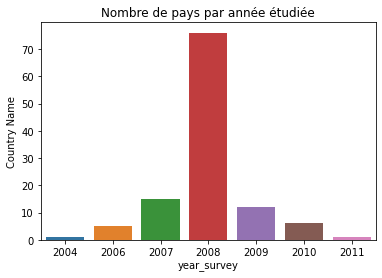

In [29]:
# histogramme de la représentation des pays
sns.barplot(x='year_survey', y='Country Name', data=year_data)
plt.title('Nombre de pays par année étudiée')
plt.savefig('p7_nb_pays_par_annee.jpg')
plt.show()

Nombre de pays présents

In [30]:
# affichage du nombre de pays étudiés
df_len = len(data['Country Name'].unique())
print('Nombre de pays étudiés:', df_len)

Nombre de pays étudiés: 116


Population couverte par l'analyse (en termes de pourcentage de la population mondiale)

In [31]:
pop2004=data[data['year_survey']==2004]
pop2004=pop2004['2004'].unique().sum()
pop2004

17827827.0

In [32]:
pop2006=data[data['year_survey']==2006]
pop2006=pop2006['2006'].unique().sum()
pop2006

287548007.0

In [33]:
pop2007=data[data['year_survey']==2007]
pop2007=pop2007['2007'].unique().sum()
pop2007

2691886113.0

In [34]:
pop2008=data[data['year_survey']==2008]
pop2008['2008']=pd.to_numeric(pop2008['2008'], errors='coerce')
pop2008=pop2008['2008'].unique().sum()
pop2008

/tmp/ipykernel_132/2549506122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop2008['2008']=pd.to_numeric(pop2008['2008'], errors='coerce')


2326671199.0

In [35]:
pop2009=data[data['year_survey']==2009]
pop2009=pop2009['2009'].unique().sum()
pop2009

466148604.0

In [36]:
pop2010=data[data['year_survey']==2010]
pop2010=pop2010['2010'].unique().sum()
pop2010

383832444.0

In [37]:
pop2011=data[data['year_survey']==2011]
pop2011=pop2011['2011'].unique().sum()
pop2011

14521515.0

In [38]:
pop_sum = pop2004 + pop2006 + pop2007 + pop2008 + pop2009 + pop2010 + pop2011
pop_sum

6188435709.0

In [39]:
studied_pop = pop_sum / wld_pop_mean * 100
print('population étudiée:', studied_pop)

population étudiée: 259    91.73763
dtype: float64


Type de quantiles

In [40]:
# le jeu de données est partitionné en centiles
data['quantile'].describe()

count    11600.000000
mean        50.500000
std         28.867314
min          1.000000
25%         25.750000
50%         50.500000
75%         75.250000
max        100.000000
Name: quantile, dtype: float64

Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode
? Pourquoi ?

Un quantile permet de séparer les données d'une distribution en intervalles réguliers.
Le centile convient parfaitement ici car il s'agit d'un très gros échantillon.

# Mission 2

In [41]:
gini=pd.read_csv('API_SI.POV.GINI_DS2_en_csv_v2_4333947.csv', skiprows=4)

In [42]:
gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN,NaN


In [43]:
gini['2008'].isna().sum()

192

In [44]:
gini_2008= gini[['Country Name', 'Country Code', 'Indicator Name', '2008']]
gini_2008.head()

,Country Name,Country Code,Indicator Name,2008
0,Aruba,ABW,Gini index,NaN
1,Africa Eastern and Southern,AFE,Gini index,NaN
2,Afghanistan,AFG,Gini index,NaN
3,Africa Western and Central,AFW,Gini index,NaN
4,Angola,AGO,Gini index,42.7


In [45]:
gini_2008.describe()

,2008
count,74.000000
mean,37.543243
std,8.924525
min,23.700000
25%,30.950000
50%,35.000000
75%,43.150000
max,63.000000


In [46]:
#Liste des pays
country = data['Country Name'].drop_duplicates().values

#Création colonne vide
data['gini'] = 0

#Calcul de l'indice de Gini pour chaque pays
for i in country:
    income = data.loc[data['Country Name'] == i].income.values
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([0], lorenz)
    data.loc[data['Country Name'] == i, 'gini'] = 2 * (0.5 - (lorenz[:-1].sum() / len(lorenz)))

In [47]:
data_2008=data[['Country Name', 'Country Code', '2008', 'gdpppp', 'gini']]
data_2008.head()

,Country Name,Country Code,2008,gdpppp,gini
0,Albanie,ALB,2947314.0,7297.0,0.32141
1,Albanie,ALB,2947314.0,7297.0,0.32141
2,Albanie,ALB,2947314.0,7297.0,0.32141
3,Albanie,ALB,2947314.0,7297.0,0.32141
4,Albanie,ALB,2947314.0,7297.0,0.32141


In [48]:
data_2008.rename(columns={'2008':'population'}, inplace=True)

/home/kipengui/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [49]:
data_clustering = data_2008[["gdpppp", "gini", 'Country Code']].groupby(by=['Country Code']).mean()
data_clustering.head()

,gdpppp,gini
Country Code,,
ALB,7297.0,0.321410
ARG,13220.0,0.465249
ARM,5611.0,0.280305
AUT,36193.0,0.295326
AZE,8101.0,0.329031


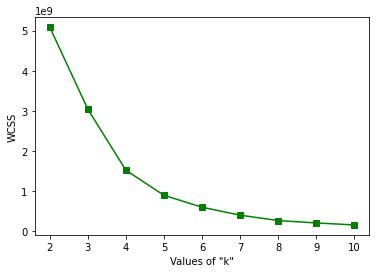

In [50]:
wcss = {}
for k in range(2,11):
    model = KMeans(n_clusters=k)
    preprocessing.StandardScaler().fit_transform(data_clustering)
    model.fit(data_clustering)
    wcss[k] = model.inertia_
     
# plotting the wcss values
# to find out the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.savefig('p7_nb_clusters.jpg')
plt.show()

In [51]:
kmeans = cluster.KMeans(n_clusters=5)

In [52]:
print(kmeans.fit(data_clustering))
print(kmeans.labels_)
print(kmeans.cluster_centers_)

KMeans(n_clusters=5)
[0 0 4 1 0 1 4 4 0 0 0 4 0 4 4 1 0 4 4 4 4 0 0 3 3 1 1 0 0 4 3 3 1 4 1 1 4
 4 4 3 4 4 3 3 4 4 1 0 4 1 3 3 4 1 0 4 4 4 3 4 4 4 3 2 0 4 4 4 0 0 4 0 4 4
 4 4 0 4 4 4 1 1 4 4 0 0 4 0 3 4 4 0 0 4 4 0 3 3 1 4 4 0 4 4 0 3 4 4 0 0 1
 0 4 4 4 0]
[[1.06695806e+04 4.36850383e-01]
 [3.62291333e+04 3.21570241e-01]
 [7.31270000e+04 3.09836792e-01]
 [2.29736000e+04 3.24754247e-01]
 [2.62748516e+03 4.12498117e-01]]


In [53]:
#index triés des groupes
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes
group_df = pd.DataFrame({"clusters":kmeans.labels_[idk]},data_clustering.index[idk])

In [54]:
for i in range(5):
    print(group_df[group_df['clusters'] == i])

              clusters
Country Code          
ALB                  0
ECU                  0
IRN                  0
KAZ                  0
LVA                  0
MEX                  0
MKD                  0
MNE                  0
MYS                  0
PAN                  0
PER                  0
POL                  0
ROU                  0
RUS                  0
SRB                  0
THA                  0
TUR                  0
UKR                  0
URY                  0
VEN                  0
DOM                  0
CRI                  0
ZAF                  0
BRA                  0
BLR                  0
BIH                  0
ARG                  0
COL                  0
AZE                  0
CHL                  0
BGR                  0
              clusters
Country Code          
NLD                  1
ISL                  1
BEL                  1
SWE                  1
IRL                  1
JPN                  1
AUT                  1
GBR                  1
FRA        

In [55]:
group_df[group_df['clusters']==1].sample()

,clusters
Country Code,
FRA,1


In [56]:
groupe_distance_df = pd.DataFrame(kmeans.transform(data_clustering), data_clustering.index)
groupe_distance_df 

,0,1,2,3,4
Country Code,,,,,
ALB,3372.580647,28932.133333,65830.000000,15676.600000,4669.514839
ARG,2550.419355,23009.133334,59907.000000,9753.600001,10592.514838
ARM,5058.580648,30618.133333,67516.000000,17362.600000,2983.514841
AUT,25523.419355,36.133343,36934.000000,13219.400000,33565.514838
AZE,2568.580647,28128.133333,65026.000000,14872.600000,5473.514839
...,...,...,...,...,...
VEN,1086.419355,24473.133334,61371.000000,11217.600001,9128.514838
VNM,8091.580645,33651.133333,70549.000000,20395.600000,49.485165
XKX,7638.580646,33198.133333,70096.000000,19942.600000,403.514846


In [57]:
# un pays choisi par cluster
countries=['BLR', 'ISL', 'HRV', 'LKA', 'FRA']
df_selected_countries=data.loc[data['Country Code'].isin(countries)]
df_selected_countries.head()

,Country Code,gdpppp,income,nb_quantiles,quantile,year_survey,Country Name,2004,2006,2007,2008,2009,2010,2011,gini
1000,BLR,11651.0,913.44214,100,1,2008,Bélarus,9730146.0,9604924.0,9560953.0,9527985.0,9504583.0,9483836.0,9461643.0,0.283292
1001,BLR,11651.0,1178.74440,100,2,2008,Bélarus,9730146.0,9604924.0,9560953.0,9527985.0,9504583.0,9483836.0,9461643.0,0.283292
1002,BLR,11651.0,1312.88370,100,3,2008,Bélarus,9730146.0,9604924.0,9560953.0,9527985.0,9504583.0,9483836.0,9461643.0,0.283292
1003,BLR,11651.0,1411.40270,100,4,2008,Bélarus,9730146.0,9604924.0,9560953.0,9527985.0,9504583.0,9483836.0,9461643.0,0.283292
1004,BLR,11651.0,1512.57530,100,5,2008,Bélarus,9730146.0,9604924.0,9560953.0,9527985.0,9504583.0,9483836.0,9461643.0,0.283292


Diversité des pays en termes de distribution de revenus

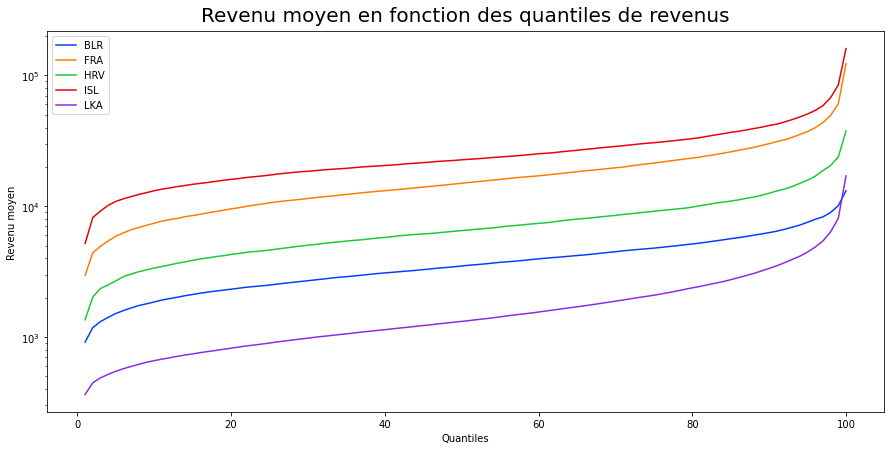

In [58]:
plt.figure(figsize=(15, 7))

sns.lineplot(x=df_selected_countries['quantile'], y=df_selected_countries['income'], hue=df_selected_countries['Country Code'], 
             data=df_selected_countries, palette='bright')
plt.xlabel("Quantiles")
plt.ylabel("Revenu moyen")
plt.yscale("log")
plt.legend()
plt.title("Revenu moyen en fonction des quantiles de revenus", pad=10, fontsize=20)
plt.savefig('p7_revenu_en_fct_quantiles.jpg')

plt.show()

Courbe de Lorenz

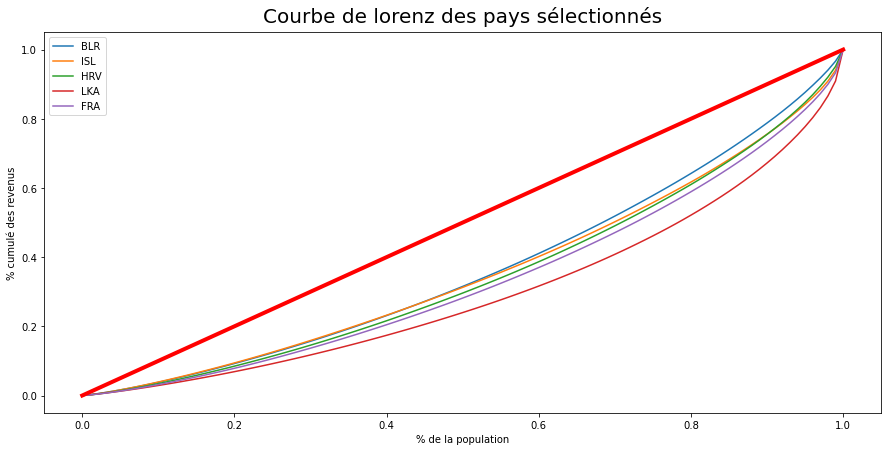

In [59]:
fig= plt.figure(figsize=(15, 7))


for i in range(len(countries)):

    temp=df_selected_countries.loc[(df_selected_countries['Country Code']==countries[i]),:]
    dep = temp['income'].values
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    plt.plot(np.linspace(0,1,len(lorenz)),lorenz,
         label=countries[i])
    # Paramètre de la bisectrice
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'red', linestyle='-', linewidth=4)

plt.xlabel('% de la population')
plt.ylabel('% cumulé des revenus')
plt.legend()
plt.title("Courbe de lorenz des pays sélectionnés", pad=10, fontsize=20)
plt.savefig('p7_courbe_lorenz.jpg')
plt.show()

In [60]:
df_selected_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 6199
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  500 non-null    object 
 1   gdpppp        500 non-null    float64
 2   income        500 non-null    float64
 3   nb_quantiles  500 non-null    int64  
 4   quantile      500 non-null    int64  
 5   year_survey   500 non-null    int64  
 6   Country Name  500 non-null    object 
 7   2004          500 non-null    object 
 8   2006          500 non-null    object 
 9   2007          500 non-null    object 
 10  2008          500 non-null    object 
 11  2009          500 non-null    object 
 12  2010          500 non-null    object 
 13  2011          500 non-null    object 
 14  gini          500 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 78.7+ KB


In [61]:
gini[['Country Name', 'Country Code', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]

,Country Name,Country Code,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,30.3,NaN,NaN,31.8,33.3,27.8
262,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,NaN,NaN,NaN,63.0,NaN,63.4,NaN
264,Zambia,ZMB,54.3,54.6,NaN,NaN,NaN,55.6,NaN


Évolution de l'indice de Gini au fil des ans

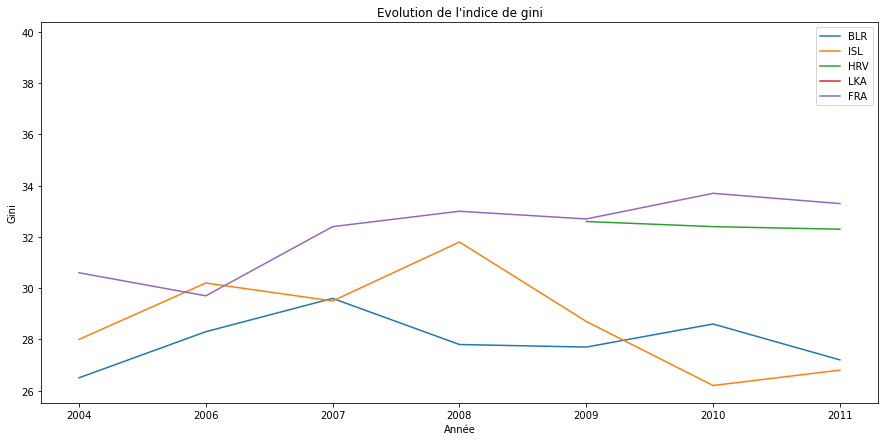

In [62]:
plt.figure(figsize=(15,7))
annee=['2004', '2006', '2007', '2008', '2009', '2010', '2011']
for i in range(len(countries)):
    transpose=gini.loc[(gini['Country Code']==countries[i]), annee].T
    plt.plot(annee, transpose, label=countries[i])
plt.xlabel('Année')
plt.ylabel('Gini')
plt.legend()
plt.title("Evolution de l'indice de gini")
plt.savefig('p7_evolution_gini.jpg')
plt.show()

In [63]:
print("La moyenne des indices de gini est de :", round(data['gini'].mean() * 100, 2))

La moyenne des indices de gini est de : 39.5


5 pays ayant l'indice de Gini le plus élevé

In [64]:
data_clustering.sort_values(by='gini', ascending=False).head()

,gdpppp,gini
Country Code,,
ZAF,9602.0,0.682949
HND,3628.0,0.615512
COL,8185.0,0.583437
GTM,4367.0,0.582468
CAF,685.0,0.575972


5 pays ayant l'indice de Gini le plus faible

In [65]:
data_clustering.sort_values(by='gini').head()

,gdpppp,gini
Country Code,,
SVN,27197.0,0.248249
SVK,20515.0,0.264573
CZE,23223.0,0.270162
SWE,34371.0,0.272166
UKR,6721.0,0.272415


Position de la France

In [66]:
data_clustering['gini_ranking'] = data_clustering['gini'].rank(ascending=True)
data_clustering[data_clustering.index=='FRA']

,gdpppp,gini,gini_ranking
Country Code,,,
FRA,30357.0,0.34564,40.0


In [67]:
data=data[['Country Code', 'Country Name', 'gdpppp', 'income', 'quantile', 'gini']]

In [68]:
zipfile.ZipFile('projet_7.zip').extractall('.')

In [69]:
with zipfile.ZipFile('projet_7.zip') as archive:
        archive.printdir()

File Name                                             Modified             Size
elasticity.txt                                 2017-05-07 23:19:04         1962
world_income_distribution.csv                  2018-06-16 21:06:52       523794


In [70]:
# fichier contenant les coefficients d'élasticité selon les régions 
with open('elasticity.txt') as f:
    contents=f.read()
    print(contents)

Coefficients of intergenerational elasticity between parents’ and
children’s income


                          | Base case  | Optimistic     | Pessimistic
                          |            | (high mobility)| (low mobility)
---------------------------------------------------------------------------
Nordic European countries |    0.2     |      0.15      |    0.3
and Canada                |            |                |
---------------------------------------------------------------------------
Europe (except nordic     |    0.4     |      0.3       |    0.5
countries)                |            |                |
---------------------------------------------------------------------------
Australia/New Zealand/USA |    0.4     |      0.3       |    0.5
---------------------------------------------------------------------------
Asia                      |    0.5     |      0.4       |    0.6
---------------------------------------------------------------------------
Latin America/A

In [71]:
# fichier contenant les coefficients d'élasticité (cf:'IGEincome')
gdim=pd.read_csv('GDIMMay2018.csv')
gdim

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1948.0,0.010193,912.0,0.098336,NaN,NaN,NaN,NaN,0.16
6501,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,4375.0,0.016527,2269.0,0.072795,NaN,NaN,NaN,NaN,0.16
6502,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,2109.0,0.011469,1183.0,0.088865,NaN,NaN,NaN,NaN,0.16


In [72]:
gdim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   countryname        6504 non-null   object 
 1   wbcode             6504 non-null   object 
 2   iso3               6504 non-null   object 
 3   region             6504 non-null   object 
 4   incgroup2          6504 non-null   object 
 5   incgroup4          6504 non-null   object 
 6   fragile            6504 non-null   int64  
 7   survey             6501 non-null   object 
 8   year               6504 non-null   int64  
 9   status             6501 non-null   object 
 10  cohort             6504 non-null   int64  
 11  parent             6504 non-null   object 
 12  child              6504 non-null   object 
 13  obs                6501 non-null   float64
 14  P1                 6501 non-null   float64
 15  P2                 6501 non-null   float64
 16  P3                 6501 

In [73]:
gdim['IGEincome'].describe()

count    853.000000
mean       0.516928
std        0.249615
min        0.112876
25%        0.312578
50%        0.464077
75%        0.689613
max        1.095440
Name: IGEincome, dtype: float64

In [74]:
IGEi=gdim[['countryname','IGEincome']].copy()

In [75]:
IGEi.drop_duplicates()

,countryname,IGEincome
0,Afghanistan,NaN
12,Angola,NaN
24,Albania,NaN
60,Albania,0.815874
84,Argentina,NaN
...,...,...
6402,South Africa,NaN
6426,South Africa,0.677000
6462,"Congo, Dem. Rep.",NaN
6480,"Congo, Dem. Rep.",0.707703


In [76]:
valid_IGEi=IGEi[IGEi['IGEincome'].isna()==False]

In [77]:
valid_IGEi

,countryname,IGEincome
60,Albania,0.815874
61,Albania,0.815874
62,Albania,0.815874
63,Albania,0.815874
64,Albania,0.815874
...,...,...
6481,"Congo, Dem. Rep.",0.707703
6482,"Congo, Dem. Rep.",0.707703
6483,"Congo, Dem. Rep.",0.707703
6484,"Congo, Dem. Rep.",0.707703


In [78]:
valid_IGEi.drop_duplicates(inplace=True)
valid_IGEi.rename(columns={'countryname':'Country Name'}, inplace=True)

/home/kipengui/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/kipengui/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [79]:
# fichier contenant les régions
metadata_gini = pd.read_csv('Metadata_Country_API_SI.POV.GINI_DS2_en_csv_v2_4333947.csv')
metadata_gini

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [80]:
meta_pop = metadata_gini[['Country Code', 'Region']]
meta_pop

,Country Code,Region
0,ABW,Latin America & Caribbean
1,AFE,NaN
2,AFG,South Asia
3,AFW,NaN
4,AGO,Sub-Saharan Africa
...,...,...
260,XKX,Europe & Central Asia
261,YEM,Middle East & North Africa
262,ZAF,Sub-Saharan Africa
263,ZMB,Sub-Saharan Africa


In [81]:
# jointure entre le jeu de données de base et les régions
data=pd.merge(data, meta_pop, on='Country Code', how='left')
data

,Country Code,Country Name,gdpppp,income,quantile,gini,Region
0,ALB,Albanie,7297.0,728.89795,1,0.321410,Europe & Central Asia
1,ALB,Albanie,7297.0,916.66235,2,0.321410,Europe & Central Asia
2,ALB,Albanie,7297.0,1010.91600,3,0.321410,Europe & Central Asia
3,ALB,Albanie,7297.0,1086.90780,4,0.321410,Europe & Central Asia
4,ALB,Albanie,7297.0,1132.69970,5,0.321410,Europe & Central Asia
...,...,...,...,...,...,...,...
11595,ZAF,Afrique du Sud,9602.0,24553.56800,96,0.682949,Sub-Saharan Africa
11596,ZAF,Afrique du Sud,9602.0,28858.03100,97,0.682949,Sub-Saharan Africa
11597,ZAF,Afrique du Sud,9602.0,35750.29000,98,0.682949,Sub-Saharan Africa
11598,ZAF,Afrique du Sud,9602.0,46297.31600,99,0.682949,Sub-Saharan Africa


In [82]:
# pas de 'Region' pour Taiwan
data[data['Region'].isna()==True]

,Country Code,Country Name,gdpppp,income,quantile,gini,Region
10500,TWN,Taiwan,25342.0,3477.1800,1,0.331487,NaN
10501,TWN,Taiwan,25342.0,4740.2637,2,0.331487,NaN
10502,TWN,Taiwan,25342.0,5331.3013,3,0.331487,NaN
10503,TWN,Taiwan,25342.0,5761.6577,4,0.331487,NaN
10504,TWN,Taiwan,25342.0,6093.2017,5,0.331487,NaN
...,...,...,...,...,...,...,...
10595,TWN,Taiwan,25342.0,38123.4600,96,0.331487,NaN
10596,TWN,Taiwan,25342.0,41663.7900,97,0.331487,NaN
10597,TWN,Taiwan,25342.0,46650.5820,98,0.331487,NaN
10598,TWN,Taiwan,25342.0,54016.9920,99,0.331487,NaN


In [83]:
data['Region'].fillna('East Asia & Pacific', inplace=True)

In [84]:
# jointure entre le jeu de données de base et les coefficients d'élasticité de GDIM
data=data.merge(valid_IGEi, on='Country Name', how='left')
data

,Country Code,Country Name,gdpppp,income,quantile,gini,Region,IGEincome
0,ALB,Albanie,7297.0,728.89795,1,0.321410,Europe & Central Asia,NaN
1,ALB,Albanie,7297.0,916.66235,2,0.321410,Europe & Central Asia,NaN
2,ALB,Albanie,7297.0,1010.91600,3,0.321410,Europe & Central Asia,NaN
3,ALB,Albanie,7297.0,1086.90780,4,0.321410,Europe & Central Asia,NaN
4,ALB,Albanie,7297.0,1132.69970,5,0.321410,Europe & Central Asia,NaN
...,...,...,...,...,...,...,...,...
11595,ZAF,Afrique du Sud,9602.0,24553.56800,96,0.682949,Sub-Saharan Africa,NaN
11596,ZAF,Afrique du Sud,9602.0,28858.03100,97,0.682949,Sub-Saharan Africa,NaN
11597,ZAF,Afrique du Sud,9602.0,35750.29000,98,0.682949,Sub-Saharan Africa,NaN
11598,ZAF,Afrique du Sud,9602.0,46297.31600,99,0.682949,Sub-Saharan Africa,NaN


In [85]:
data['Region'].unique()

array(['Europe & Central Asia', 'Latin America & Caribbean',
       'Sub-Saharan Africa', 'South Asia', 'North America',
       'East Asia & Pacific', 'Middle East & North Africa'], dtype=object)

In [86]:
# attribution des coefficients d'élasticité selon les régions pour les pays qui n'en nont pas dans GDIM
eurasia=data[data['Region']=='Europe & Central Asia'].copy()
eurasia['IGEincome'].fillna(0.4, inplace=True)

latin_am=data[data['Region']=='Latin America & Caribbean'].copy()
latin_am['IGEincome'].fillna(0.5, inplace=True)

sth_africa=data[data['Region']=='Sub-Saharan Africa'].copy()
sth_africa['IGEincome'].fillna(0.66, inplace=True)

sth_asia=data[data['Region']=='South Asia'].copy()
sth_asia['IGEincome'].fillna(0.5, inplace=True)

nth_am=data[data['Region']=='North America'].copy()
nth_am['IGEincome'].fillna(0.2, inplace=True)

east_asia=data[data['Region']=='East Asia & Pacific'].copy()
east_asia['IGEincome'].fillna(0.5, inplace=True)

mena=data[data['Region']=='Middle East & North Africa'].copy()
mena['IGEincome'].fillna(0.5, inplace=True)

In [87]:
data=eurasia.merge(latin_am, how='outer') \
.merge(sth_africa, how='outer') \
.merge(sth_asia, how='outer') \
.merge(nth_am, how='outer') \
.merge(east_asia, how='outer') \
.merge(mena, how='outer')

data.rename(columns={'quantile':'c_i_child'}, inplace=True)
data

,Country Code,Country Name,gdpppp,income,c_i_child,gini,Region,IGEincome
0,ALB,Albanie,7297.0,728.89795,1,0.321410,Europe & Central Asia,0.4
1,ALB,Albanie,7297.0,916.66235,2,0.321410,Europe & Central Asia,0.4
2,ALB,Albanie,7297.0,1010.91600,3,0.321410,Europe & Central Asia,0.4
3,ALB,Albanie,7297.0,1086.90780,4,0.321410,Europe & Central Asia,0.4
4,ALB,Albanie,7297.0,1132.69970,5,0.321410,Europe & Central Asia,0.4
...,...,...,...,...,...,...,...,...
11595,YEM,"Yémen, Rép. du",2224.0,2568.65110,96,0.390259,Middle East & North Africa,0.5
11596,YEM,"Yémen, Rép. du",2224.0,2893.90400,97,0.390259,Middle East & North Africa,0.5
11597,YEM,"Yémen, Rép. du",2224.0,3307.27220,98,0.390259,Middle East & North Africa,0.5
11598,YEM,"Yémen, Rép. du",2224.0,4137.02640,99,0.390259,Middle East & North Africa,0.5


In [88]:
data['IGEincome'].unique()

array([0.4       , 0.3571051 , 0.2379952 , 0.3807922 , 0.2823753 ,
       0.5       , 1.015206  , 0.9668646 , 0.66      , 0.561605  ,
       0.6703727 , 0.6896126 , 0.7139534 , 0.7402018 , 0.538     ,
       0.4505    , 0.26933333, 0.2       , 0.7019939 ])

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  11600 non-null  object 
 1   Country Name  11600 non-null  object 
 2   gdpppp        11600 non-null  float64
 3   income        11600 non-null  float64
 4   c_i_child     11600 non-null  int64  
 5   gini          11600 non-null  float64
 6   Region        11600 non-null  object 
 7   IGEincome     11600 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 815.6+ KB


Faible mobilité

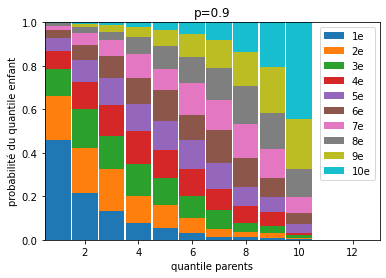

[[0.458 0.214 0.134 0.077 0.053 0.031 0.013 0.011 0.007 0.002]
 [0.202 0.21  0.191 0.124 0.108 0.071 0.038 0.027 0.024 0.005]
 [0.125 0.177 0.151 0.149 0.125 0.099 0.087 0.04  0.032 0.015]
 [0.083 0.127 0.146 0.15  0.127 0.123 0.095 0.077 0.063 0.009]
 [0.062 0.099 0.122 0.126 0.135 0.133 0.122 0.09  0.07  0.041]
 [0.037 0.068 0.101 0.118 0.139 0.118 0.149 0.13  0.087 0.053]
 [0.014 0.055 0.074 0.11  0.1   0.146 0.139 0.156 0.133 0.073]
 [0.015 0.027 0.037 0.078 0.103 0.119 0.147 0.177 0.168 0.129]
 [0.003 0.016 0.033 0.045 0.075 0.105 0.128 0.156 0.211 0.228]
 [0.001 0.007 0.011 0.023 0.035 0.055 0.082 0.136 0.205 0.445]]

P(c_i_parent = 3 | c_i_child = 2, pj = 0.9) = 0.149


In [90]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 2 
c_i_parent = 3
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

Forte mobilité

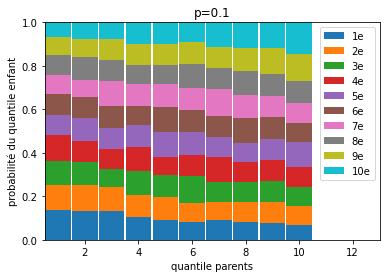

[[0.137 0.133 0.133 0.104 0.091 0.084 0.091 0.08  0.078 0.069]
 [0.117 0.12  0.108 0.104 0.106 0.083 0.084 0.096 0.094 0.088]
 [0.107 0.107 0.085 0.11  0.099 0.125 0.091 0.09  0.098 0.088]
 [0.121 0.096 0.092 0.11  0.086 0.1   0.115 0.093 0.095 0.092]
 [0.091 0.104 0.098 0.098 0.116 0.103 0.093 0.086 0.098 0.113]
 [0.098 0.096 0.1   0.09  0.112 0.104 0.097 0.117 0.1   0.086]
 [0.087 0.077 0.113 0.102 0.107 0.101 0.121 0.104 0.097 0.091]
 [0.092 0.106 0.098 0.088 0.087 0.108 0.1   0.112 0.104 0.105]
 [0.084 0.086 0.095 0.095 0.098 0.102 0.093 0.106 0.118 0.123]
 [0.066 0.075 0.078 0.099 0.098 0.09  0.115 0.116 0.118 0.145]]

P(c_i_parent = 3 | c_i_child = 2, pj = 0.1) = 0.11


In [91]:
pj = 0.1                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 2 
c_i_parent = 3
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

Distribution conditionnelle avec la taille de l'échantillon x 1000

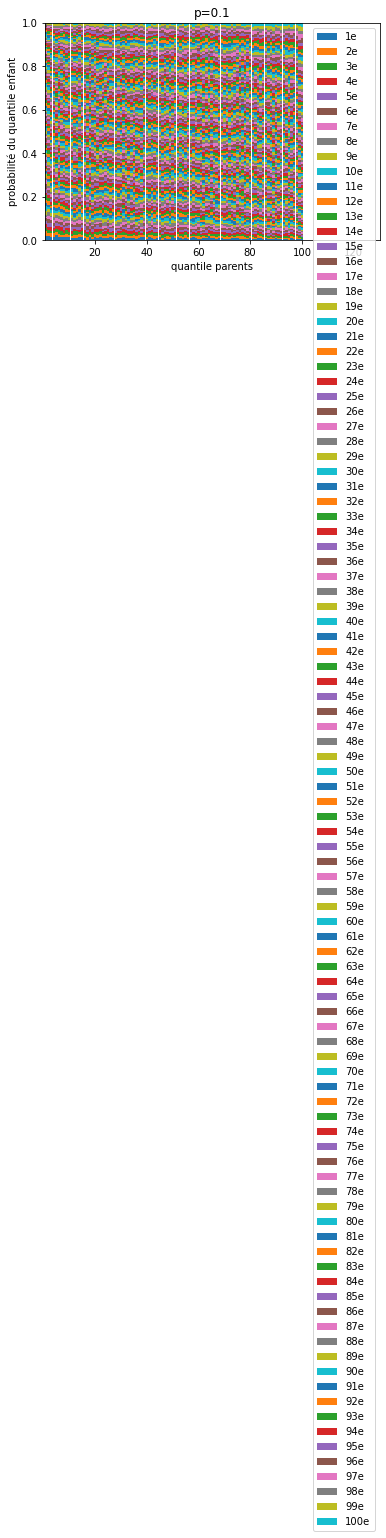

[[0.021 0.018 0.014 ... 0.008 0.006 0.004]
 [0.02  0.017 0.02  ... 0.012 0.006 0.002]
 [0.014 0.013 0.008 ... 0.004 0.008 0.009]
 ...
 [0.002 0.006 0.004 ... 0.014 0.016 0.015]
 [0.005 0.007 0.006 ... 0.018 0.021 0.016]
 [0.002 0.002 0.004 ... 0.008 0.015 0.021]]

P(c_i_parent = 3 | c_i_child = 2, pj = 0.1) = 0.011


<Figure size 432x288 with 0 Axes>

In [92]:
pj = 0.1                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 2 
c_i_parent = 3
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

plt.savefig('p7_distrib_condi_x1000.jpg')

Taille de la population x 1000

In [93]:
big_data=pd.concat([data]*1000, ignore_index=True)
big_data.head()

,Country Code,Country Name,gdpppp,income,c_i_child,gini,Region,IGEincome
0,ALB,Albanie,7297.0,728.89795,1,0.32141,Europe & Central Asia,0.4
1,ALB,Albanie,7297.0,916.66235,2,0.32141,Europe & Central Asia,0.4
2,ALB,Albanie,7297.0,1010.91600,3,0.32141,Europe & Central Asia,0.4
3,ALB,Albanie,7297.0,1086.90780,4,0.32141,Europe & Central Asia,0.4
4,ALB,Albanie,7297.0,1132.69970,5,0.32141,Europe & Central Asia,0.4


In [94]:
big_data.shape

(11600000, 8)

In [95]:
big_data['c_i_parent']=0

In [96]:
big_data['c_i_child'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [97]:
# création de la classe de revenu des parents
list_pays=big_data['Country Name'].unique()
classe_parent=0
classe_enfant=0
list_prob=[]

for pays in list_pays:
    pj=big_data.loc[big_data['Country Name']==pays,'IGEincome'].iloc[0]
    nb_quantiles = 100 # nombre de quantiles (nombre de classes de revenu)
    n = 1000 * nb_quantiles # taille de l'échantillon
    y_child, y_parents = generate_incomes(n, pj) # Calcule des revenus enfants et parents 
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd) # Probabilité conditionelle 
            list_prob.extend([c_i_parent+1]*(int(p*1000))) # distribution de cette probailité conditionelle

In [98]:
big_data['c_i_parent']=list_prob

In [99]:
big_data.head()

,Country Code,Country Name,gdpppp,income,c_i_child,gini,Region,IGEincome,c_i_parent
0,ALB,Albanie,7297.0,728.89795,1,0.32141,Europe & Central Asia,0.4,1
1,ALB,Albanie,7297.0,916.66235,2,0.32141,Europe & Central Asia,0.4,1
2,ALB,Albanie,7297.0,1010.91600,3,0.32141,Europe & Central Asia,0.4,1
3,ALB,Albanie,7297.0,1086.90780,4,0.32141,Europe & Central Asia,0.4,1
4,ALB,Albanie,7297.0,1132.69970,5,0.32141,Europe & Central Asia,0.4,1


In [100]:
big_data.to_csv('big_data.csv', index=False)